In [1]:
import pandas as pd
import os

# 현재 파이썬 코드의 파일 경로
current_path = os.getcwd()  # 현재 작업 디렉토리를 가져옵니다.

# CSV 파일 경로
file_path = os.path.join(current_path, 'filtered_data.csv')  # User uploaded fioytle to this path

df = pd.read_csv(file_path)
df

,note_id,person_id,age,gender_source_value,BMI,admission_department,division,ward,asa_class,surgeon_id,...,condition_source_value,surgery_room,previous_surgery,emergency_status,op_timing,day_of_the_week,week_of_the_month,month,surgeon_estimated_op_time,surgery_duration
0,101058,29,81,F,25.247087,General Surgery,Admission,NUGW2,2,9885,...,D00002196,203,N,N,TF2,Thursday,4,October,130,66
1,57801,64,60,F,24.376249,Otolaryngology,Admission,102,2,6194,...,D00003798,504,N,N,8A,Friday,2,January,300,130
2,71288,64,60,F,24.376249,Otolaryngology,Admission,102,3,6194,...,D00003798,504,Y,N,TF4,Monday,4,April,100,85
3,135104,64,60,F,24.376249,Otolaryngology,Admission,102,3,6194,...,D00003798,504,Y,N,TF2,Monday,3,August,100,83
4,221210,71,94,M,27.963140,Orthopedics,Admission,41,2,29473,...,D00018711,108,N,N,TF4,Monday,5,March,100,63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161214,297111,4055249,1,M,23.700428,Pediatric Surgery,Admission,5A,1,100613,...,D00011688,5,N,Y,etc,Tuesday,2,September,200,123
161215,297455,4055328,1,M,20.612160,Pediatric Urology,Day,PDSC,1,6259,...,D00016707,7,N,N,8A,Monday,4,September,130,45
161216,297761,4055407,1,M,12.502703,Pediatric Surgery,Admission,5A,2,105057,...,D00011524,5,N,N,8A,Wednesday,3,September,130,43
161217,297753,4055558,4,F,14.365794,Pediatric Surgery,Admission,5A,2,105057,...,D00004831,5,N,N,TF6,Wednesday,3,September,130,82


In [2]:
from sklearn.model_selection import train_test_split

# Removing unnecessary columns
df.drop(columns=['note_id', 'person_id', 'surgeon_estimated_op_time', 'final_op_name'], inplace=True)

# Encoding binary columns
binary_cols = ['condition_source_value', 'op_code', 'surgeon_id', 'ward', 'admission_department', 'surgery_room']
for col in binary_cols:
    df[col] = df[col].astype('category').cat.codes

# One-hot encoding for other categorical columns
one_hot_cols = ['surgical_department', 'op_timing', 'month', 'anesthesia_type', 
                'day_of_the_week', 'asa_class', 'week_of_the_month', 
                'division', 'previous_surgery', 'emergency_status', 'gender_source_value']
df_encoded = pd.get_dummies(df, columns=one_hot_cols)

# Splitting the data
X_all = df_encoded.drop("surgery_duration", axis=1)
y_all = df_encoded["surgery_duration"]
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

# Displaying the first few rows of the resulting dataframe
X_train_all
y_train_all


61344     122
137241     48
139478     76
113549     36
149411    127
         ... 
119879     76
103694     57
131932    311
146867     82
121958     57
Name: surgery_duration, Length: 128975, dtype: int64

In [3]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Function to evaluate a model
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, predictions)
    return mae, rmse, r2

# Define the models
models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42),
    "Linear Regression": LinearRegression(),
    "LightGBM": LGBMRegressor(random_state=42),  
    "Decision Tree": DecisionTreeRegressor(random_state=42)  
}

#Evaluating each model
results = {}
for name, model in models.items():
    mae, rmse, r2 = evaluate_model(model, X_train_all, y_train_all, X_test_all, y_test_all)
    results[name] = {"MAE": mae, "RMSE": rmse, "R2": r2}


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006110 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1347
[LightGBM] [Info] Number of data points in the train set: 128975, number of used features: 90
[LightGBM] [Info] Start training from score 136.030665


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_28488\553525220.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[val for key, val in sorted_importances], y=[key for key, val in sorted_importances], palette="viridis")


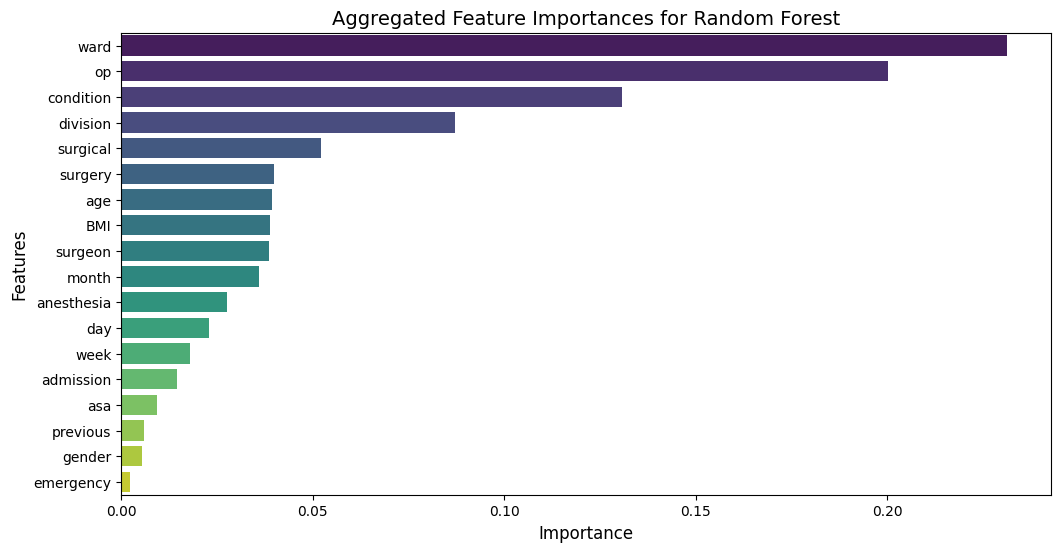

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming 'Random Forest' model has been trained and is in the 'models' dictionary
random_forest_model = models['Random Forest']

# Get feature importances from the Random Forest model
importances = random_forest_model.feature_importances_

# Aggregate importances for one-hot encoded features
aggregated_importances = {}
for i, col in enumerate(X_train_all.columns):
    original_feature = col.split('_')[0]  # Extracting the base feature name
    if original_feature not in aggregated_importances:
        aggregated_importances[original_feature] = 0
    aggregated_importances[original_feature] += importances[i]

# Sort the aggregated importances in descending order
sorted_importances = sorted(aggregated_importances.items(), key=lambda x: x[1], reverse=True)

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x=[val for key, val in sorted_importances], y=[key for key, val in sorted_importances], palette="viridis")
plt.title('Aggregated Feature Importances for Random Forest', fontsize=14)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.show()


In [4]:
results

{'Random Forest': {'MAE': 34.04604403920109,
  'RMSE': 57.451605225030455,
  'R2': 0.7228655762174734},
 'XGBoost': {'MAE': 36.200432767370856,
  'RMSE': 59.30818293047968,
  'R2': 0.7046646885862251},
 'Linear Regression': {'MAE': 60.20856700850626,
  'RMSE': 87.47948783970479,
  'R2': 0.35746231743419077},
 'LightGBM': {'MAE': 38.36633326935028,
  'RMSE': 61.60987547045354,
  'R2': 0.6812965233825812},
 'Decision Tree': {'MAE': 46.948982756481826,
  'RMSE': 80.1913318399825,
  'R2': 0.460065607372496}}